# Theory of Shor's Algorithm

Shor’s algorithm is one of the landmark results in quantum computing: it allows the factorization of very large integers in polynomial time, breaking the hardness assumption underlying many classical cryptosystems (such as RSA).\
The goal of the algorithm is to factorize a number:
$$
N = p \cdot q
$$
where \(p\) and \(q\) are unknown prime numbers.

## Reducing Factoring to Period Finding

We choose an integer \(a\) such that:
$$
1 < a < N, \qquad \gcd(a, N) = 1.
$$

Then we consider the function:
$$
f(x) = a^x \bmod N.
$$

Because this function operates modulo \(N\), it is necessarily periodic.  There exists a smallest positive integer \(r\) such that:
$$
a^r \equiv 1 \pmod{N}.
$$

This integer \(r\) is called the \emph{order} (or period) of \(a\) modulo \(N\).\
If the period \(r\) is even, then:
$$
a^r \equiv 1 \pmod{N}
\quad\Rightarrow\quad
a^r - 1 \equiv 0 \pmod{N}.
$$

We can factor this expression:
$$
a^r - 1 = (a^{r/2} - 1)(a^{r/2} + 1).
$$

Since \(N\) divides this product, at least one of the two factors must share a non-trivial divisor with \(N\).  
We can find the two candidates:
$$
p = \gcd(a^{r/2} - 1,\, N),
\qquad
q = \gcd(a^{r/2} + 1,\, N).
$$

If neither \(p\) nor \(q\) equals \(1\) or \(N\), then we have successfully recovered a factor of \(N\).

## The Quantum Component: Quantum Phase Estimation (QPE)

The classically hard part is finding the period \(r\).  
A quantum computer solves this efficiently using Quantum Phase Estimation (QPE).

We define the unitary operator:
$$
U_a \, |x\rangle = |a x \bmod N\rangle.
$$

This operator has eigenvectors \(|u_k\rangle\) with eigenvalues:
$$
U_a |u_k\rangle = e^{2\pi i k / r} |u_k\rangle.
$$

Thus, each eigenvector corresponds to a phase:
$$
\phi = \frac{k}{r}.
$$

QPE allows us to estimate this phase \(\phi\) with high precision using:

* a counting register,
* a target register on which \(U_a\) acts.

The measurement result is a binary approximation of the phase:
$$
\tilde{\phi} \approx \frac{k}{r}.
$$

## Extracting the Period via Continued Fractions

The QPE output corresponds to:
$$
\tilde{\phi} = \frac{\text{output}}{2^n},
$$
where \(n\) is the number of qubits used in the counting register.

To recover the period \(r\), we approximate \(\tilde{\phi}\) using continued fractions:
$$
\frac{k}{r}
=
\mathrm{ContinuedFractionApprox}(\tilde{\phi}).
$$

The denominator of the resulting reduced fraction provides a candidate value for \(r\).  
With a sufficiently large counting register, the probability of obtaining the correct period is very high.

# Code implementation

First we import the libraries and packages that we will use.

In [48]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import numpy as np
from fractions import Fraction
from math import gcd, log2, ceil


Then we proceed to implement the unitary matrix U defined by the action
$$
U\ket{x}= \left\{ \begin{array}{cl}
\ket{ax (\text{mod}N)} &  \ 0 \le x < N\\
\ket{x} &  \ N\le X < 2^n
\end{array} \right.
$$
to do this we create a unitary matrix that if $x<N$:
$$U_{y,x} = 1  \quad \text{where} \quad y = ax (\text{mod}N)$$
and if $x \ge N$:
$$U_{x,x}  = 1 $$

In [49]:
def U_matrix(a, N, n_qubits):
    """Create matrix for |x> -> |a*x mod N>, only acting on valid x < N."""
    dim = 2**n_qubits
    U = np.eye(dim, dtype=complex)
    
    for x in range(N):  # modify only valid basis states
        y = (a * x) % N
        U[y, x] = 1
        if y != x:
            U[x, x] = 0
    return U

The choice
$$
n_{\text{target}} = \lceil \log_2(N) \rceil
$$
comes from the fact that we need at least $(log_2(N))$ qubits to represent in binary all values \(0, 1, \dots, N-1\). The target register must 
store the states on which the operator $(U : |y\rangle \mapsto |a y \bmod N\rangle)$ acts, 
so its Hilbert space must have dimension at least $(N)$.

The choice
$$
n_{\text{count}} = 2\, n_{\text{target}}
$$
is standard in Shor's algorithm: in Quantum Phase Estimation we need about $(2 \log_2(N))$ qubits in the counting register to estimate the phase $(\theta = r/N)$ with enough precision to recover the order $(r)$ using continued fractions.


/Users/andreatagliapietra/Desktop/Quantum computing/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/andreatagliapietra/Desktop/Quantum computing/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


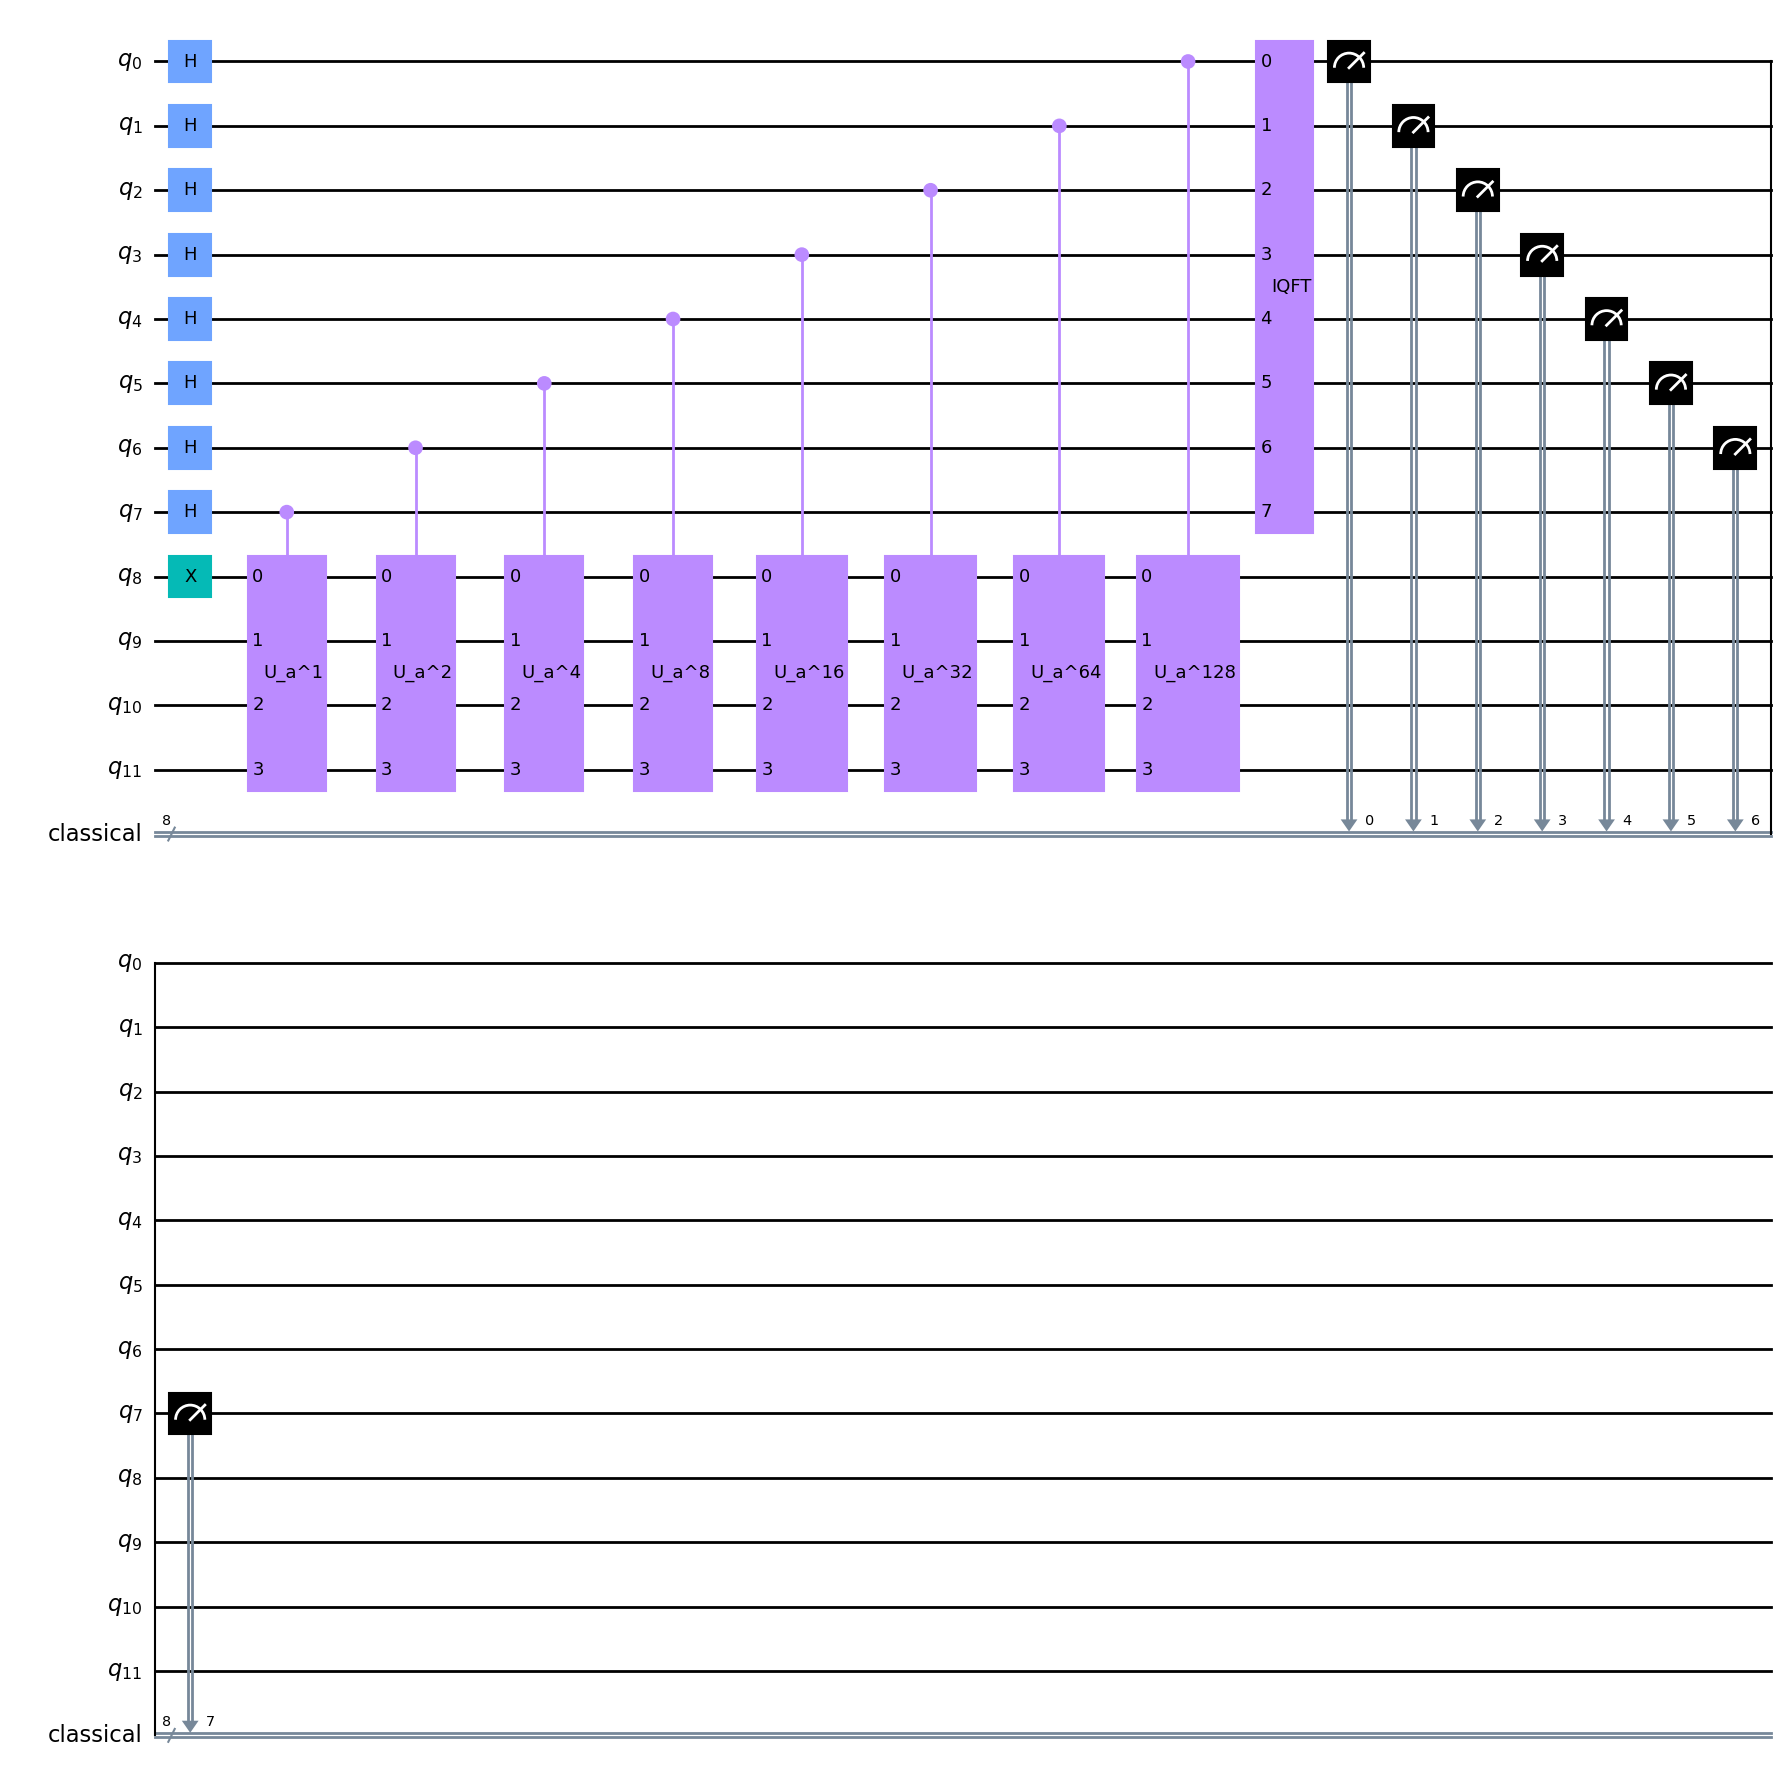

In [50]:
N = 15
a = 2

n_target = ceil(log2(N))
if 2**n_target < N:
        n_target += 1

n_count = 2 * n_target

# Build U
U = U_matrix(a, N, n_target)

qc = QuantumCircuit(n_count + n_target)

# initialize counting qubits in |+>
qc.h(range(n_count))

# initialize target register in |1>
qc.x(n_count)

# apply controlled-U^{2^j} operations
for j in range(n_count):
    power = 2**j
    U_pow = np.linalg.matrix_power(U, power)
    cu = Operator(U_pow).to_instruction()
    cu.name = f"U_a^{power}"
    ctrl = n_count - 1 - j
    qc.append(cu.control(), [ctrl] + [q for q in range(n_count, n_count + n_target)])

# inverse QFT on counting register
qc.append(QFT(n_count, inverse=True).to_instruction(), range(n_count))

# Create classical register for measurement
classical = ClassicalRegister(n_count, name='classical')
qc.add_register(classical)

# Measurement
qc.measure(range(n_count), classical)

qc.draw('mpl')

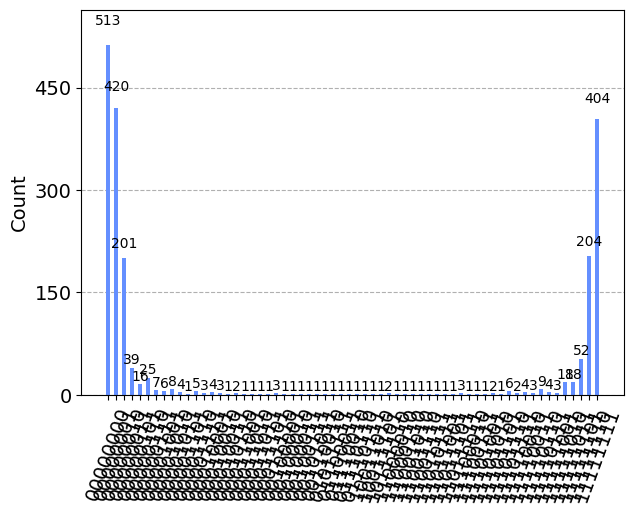

In [51]:
from qiskit import Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')

results = execute(qc, backend=simulator, shots=2024).result()

counts = results.get_counts()
plot_histogram(counts)

In [52]:
# Extract phases
phase_estimates = []
for out, cnt in counts.items():
    decimal = int(out, 2)
    phase = decimal / (2**n_count)
    # append multiple times weighted by count
    phase_estimates.extend([phase] * cnt)

# Continued fraction extraction to find order r
candidates_r = set()

for phase in phase_estimates:
    frac = Fraction(phase).limit_denominator(N)
    if frac.denominator > 1:
        candidates_r.add(frac.denominator)

print("Candidate denominators:", candidates_r)

# Pick smallest valid r
r = None
for r_try in sorted(candidates_r):
    if pow(a, r_try, N) == 1:
        r = r_try
        break

print("Recovered r =", r)

# Factor extraction
# ----------------------------------------------------------------------
if r is None:
    print("No valid period found; rerun or pick different a.")
else:
    if r % 2 == 1:
        print("Odd r detected, doubling...")
        r *= 2

    x = pow(a, r//2, N)

    if x == N - 1:
        print("Unlucky case: a^(r/2) = -1 mod N")
    else:
        p = gcd(x - 1, N)
        q = gcd(x + 1, N)
        print("Factors:", p, q)

Candidate denominators: {4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15}
Recovered r = 4
Factors: 3 5
